In [80]:
import numpy as np 

import pandas as pd 

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import statsmodels.api as sm

from prophet import Prophet

from keras.layers import Dense,Dropout,LSTM,Bidirectional
from keras.models import Sequential

In [81]:
df = pd.read_csv('PJME_hourly.csv')

<b>Data Preprocessing</b>

In [82]:
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
df.reset_index(inplace=True, drop=True)
df.rename(columns={'PJME_MW':'Demand'}, inplace=True)

In [83]:
df.drop_duplicates(subset='Datetime', keep='last', inplace=True)

In [84]:
df = df.set_index('Datetime')

In [85]:
date_range = pd.date_range(start=min(df.index), end=max(df.index), freq='H')

In [86]:
#interpolate missing values with a linear function
df = df.reindex(date_range)
df['Demand'].interpolate(method='linear', inplace=True)

In [87]:
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()
df['dom'] = df.index.day
df['date'] = df.index.date 

In [88]:
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

<b>Data Visualisation</b>

In [89]:
df['date_and_time'] = df.index

fig = px.line(df,
              x='date_and_time',
              y='Demand',
              title=f'Power Demand (MW) over time [{min(df.year)} - {max(df.year)}]')
fig.update_traces(line=dict(width=0.05))
fig.update_layout(xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

In [90]:
_ = df\
    .groupby(['hour', 'weekday'], as_index=False)\
    .agg({'Demand':'median'})

fig = px.line(_, 
              x='hour', 
              y='Demand', 
              color='weekday', 
              title='Median Hourly Power Demand per Weekday')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='Energy Demand [MW]')
fig.show()

In [91]:
_ = df\
    .groupby(['hour', 'season'], as_index=False)\
    .agg({'Demand':'median'})

fig = px.line(_,
              x='hour', 
              y='Demand', 
              color='season', 
              title='Median Hourly Power Demand per Season')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='Energy Demand [MW]')
fig.show()

1->Winter, 2->Spring, 3->Summer, 4->Autumn

<b>Forecasting Models</b>

Train/Test Split

In [92]:
CUTOFF_DATE = pd.to_datetime('2017-08-01')
TIME_DELTA = pd.DateOffset(years=8)

train = df.loc[(df.index < CUTOFF_DATE) & (df.index >= CUTOFF_DATE-TIME_DELTA) ].copy()
test = df.loc[df.index >= CUTOFF_DATE].copy()

1)Holt-Winter

In [14]:
exp_smooth_train, exp_smooth_test = train['Demand'], test['Demand']

holt_winter = sm.tsa.ExponentialSmoothing(exp_smooth_train,seasonal_periods=24*365,seasonal='add').fit()
y_hat_holt_winter = holt_winter.forecast(len(exp_smooth_test))

c:\Users\Jim\miniconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning:

Optimization failed to converge. Check mle_retvals.



In [15]:
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    pe = (y_true - y_pred) / y_true
    ape = np.abs(pe)
    mape = np.mean(ape)
    return f'{mape*100:.2f}%'

In [16]:
mape_hw = mape(y_true=exp_smooth_test, y_pred=y_hat_holt_winter)
print(f'Mean Absolute Percentage Error: {mape_hw}')

Mean Absolute Percentage Error: 10.20%


In [17]:
interval = 24 * 30

x_true, y_true = exp_smooth_test.iloc[:interval].index, exp_smooth_test.iloc[:interval]
x_pred, y_pred = y_hat_holt_winter.iloc[:interval].index, y_hat_holt_winter.iloc[:interval]

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_true, y=y_true,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=x_pred, y=y_pred,
                         mode='lines', 
                         name='Test - Prediction'))

fig.update_traces(line=dict(width=0.9))
fig.update_layout(title=f'Holt-Winter Intra-Day Forecast of First {interval} Hours of Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

print(f'MAPE for interval of the first {interval} hours: {mape(y_true, y_pred)}')

MAPE for interval of the first 720 hours: 12.84%


2)Prophet

In [94]:
train_prophet = train[['Demand']].reset_index().rename(columns={'index':'ds', 'Demand':'y'})
test_prophet = test[['Demand']].reset_index().rename(columns={'index':'ds','Demand':'y'})

In [95]:
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name() in ('Saturday', 'Sunday')


train_prophet['is_spring'] = train_prophet['ds'].apply(is_spring)
train_prophet['is_summer'] = train_prophet['ds'].apply(is_summer)
train_prophet['is_autumn'] = train_prophet['ds'].apply(is_autumn)
train_prophet['is_winter'] = train_prophet['ds'].apply(is_winter)
train_prophet['is_weekend'] = train_prophet['ds'].apply(is_weekend)
train_prophet['is_weekday'] = ~train_prophet['ds'].apply(is_weekend)


test_prophet['is_spring'] = test_prophet['ds'].apply(is_spring)
test_prophet['is_summer'] = test_prophet['ds'].apply(is_summer)
test_prophet['is_autumn'] = test_prophet['ds'].apply(is_autumn)
test_prophet['is_winter'] = test_prophet['ds'].apply(is_winter)
test_prophet['is_weekend'] = test_prophet['ds'].apply(is_weekend)
test_prophet['is_weekday'] = ~test_prophet['ds'].apply(is_weekend)

In [96]:
prophet = Prophet()

In [97]:
prophet.add_seasonality(name='yearly', period=365.25, fourier_order=10)
prophet.add_seasonality(name='weekly_spring', period=7,fourier_order=5, condition_name='is_spring')
prophet.add_seasonality(name='weekly_summer', period=7,fourier_order=5, condition_name='is_summer')
prophet.add_seasonality(name='weekly_autumn', period=7,fourier_order=5, condition_name='is_autumn')
prophet.add_seasonality(name='weekly_winter', period=7,fourier_order=5, condition_name='is_winter')
prophet.add_seasonality(name='daily_spring',  period=1,fourier_order=5, condition_name='is_spring')
prophet.add_seasonality(name='daily_summer',  period=1,fourier_order=5, condition_name='is_summer')
prophet.add_seasonality(name='daily_autumn',  period=1,fourier_order=5, condition_name='is_autumn')
prophet.add_seasonality(name='daily_winter',  period=1,fourier_order=5, condition_name='is_winter')
prophet.add_seasonality(name='daily_weekend',  period=1,fourier_order=5, condition_name='is_weekend')
prophet.add_seasonality(name='daily_weekday',  period=1,fourier_order=5, condition_name='is_weekday')

In [98]:
prophet.fit(train_prophet)
future = test_prophet.drop(['y'], axis=1)

14:25:57 - cmdstanpy - INFO - Chain [1] start processing
14:28:12 - cmdstanpy - INFO - Chain [1] done processing


In [99]:
forecast = prophet.predict(future)

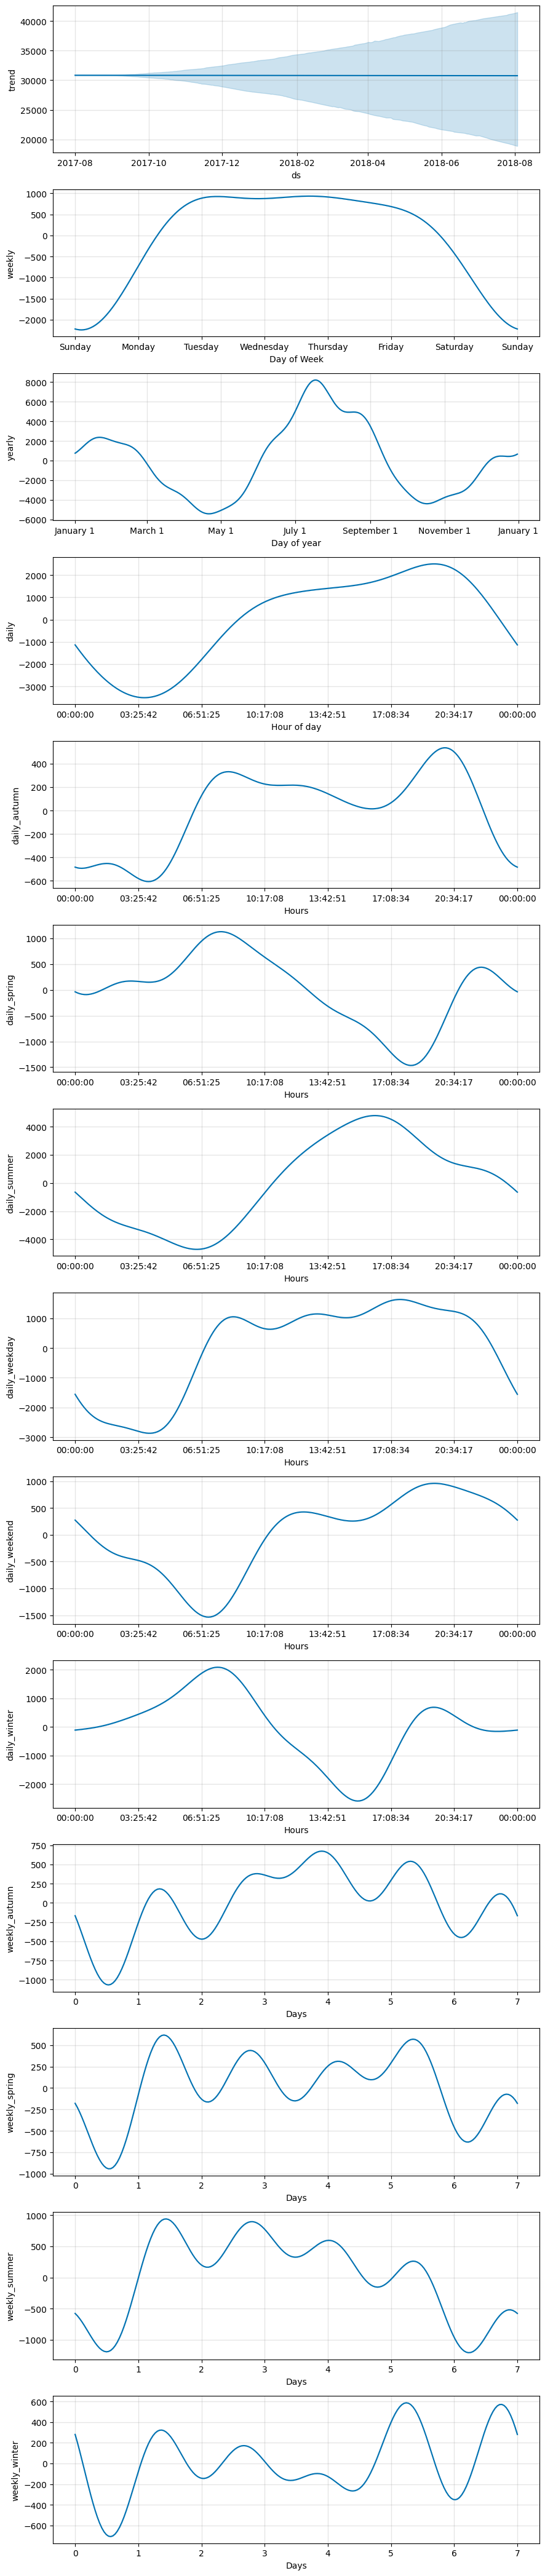

In [100]:
pd.plotting.register_matplotlib_converters()
_ = prophet.plot_components(forecast)

In [101]:
print(f'MAPE for Prophet\'s predictions: {mape(test_prophet.y, forecast.yhat)}')

MAPE for Prophet's predictions: 9.26%


In [102]:
interval = 24 * 30

x_true, y_true = test_prophet.iloc[:interval].ds, test_prophet.iloc[:interval].y
x_pred, y_pred = forecast.iloc[:interval].ds, forecast.iloc[:interval].yhat

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_true, y=y_true,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=x_pred, y=y_pred,
                         mode='lines', 
                         name='Test - Prediction'))

fig.update_traces(line=dict(width=0.9))
fig.update_layout(title=f'Prophet Intra-Day Forecast of First {interval} Hours of Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

print(f'MAPE for interval of the first {interval} hours: {mape(y_true, y_pred)}')

MAPE for interval of the first 720 hours: 10.84%


3)LSTM

In [105]:
from sklearn.preprocessing import MinMaxScaler

In [106]:
data=df[['date_and_time','Demand']].reset_index(drop=True)
data.index=data['date_and_time']
data=data.drop(columns='date_and_time')

In [108]:
def normalize_data(df):
    scaler = MinMaxScaler()
    norm_data=scaler.fit_transform(df['Demand'].values.reshape(-1,1))
    df['Demand']=norm_data
    return df,scaler

df_norm,scaler = normalize_data(data)

In [110]:
data.head()

Demand
date_and_time                
2002-01-01 01:00:00  0.333909
2002-01-01 02:00:00  0.310144
2002-01-01 03:00:00  0.291014
2002-01-01 04:00:00  0.281365
2002-01-01 05:00:00  0.284694

In [111]:
def load_data(data, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(data)):
        X_train.append(data.iloc[i-seq_len : i, 0])
        y_train.append(data.iloc[i, 0])
    
    
    X_test = X_train[110000:]
    y_test = y_train[110000:]
    x_t=X_test
    y_t=y_test
    
    X_train = X_train[:110000]           
    y_train = y_train[:110000]
    x_tr=X_train
    y_tr=y_train
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    X_train = np.reshape(X_train, (110000, seq_len, 1))
    
    X_test = np.reshape(X_test, (X_test.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_test, y_test,x_t,y_t,x_tr,y_tr]

In [112]:
seq_len = 20
X_train, y_train, X_test, y_test,x_t,y_t,x_tr,y_tr = load_data(df_norm, seq_len)

In [114]:
g=df['date_and_time'].to_numpy()

In [115]:
g[110000]

numpy.datetime64('2014-07-20T09:00:00.000000000')

C:\Users\Jim\AppData\Local\Temp\ipykernel_4940\345258320.py:2: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.

C:\Users\Jim\AppData\Local\Temp\ipykernel_4940\345258320.py:3: UserWarning:

Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.



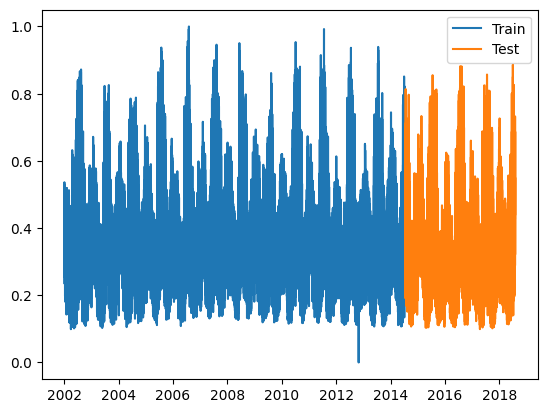

In [116]:
split_date = '20-07-2014'
train_ = df_norm.loc[df_norm.index <= split_date].copy()
test_ = df_norm.loc[df_norm.index > split_date].copy()
plt.plot(train_)
plt.plot(test_)

plt.legend(['Train', 'Test'])

In [117]:
from keras.callbacks import EarlyStopping

In [38]:
lstm_model = Sequential()
lstm_model.add(Bidirectional(LSTM(128,activation="selu",return_sequences=True, input_shape=(X_train.shape[1],1))))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(128,activation="selu",return_sequences=True)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Bidirectional(LSTM(128,activation="selu",return_sequences=False)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))



lstm_model.compile(optimizer="adam",loss="MSE")
lstm_model.summary

callback = EarlyStopping(
    monitor="loss",
    patience=2,
    restore_best_weights=True
)

lstm_model.fit(X_train, y_train, epochs=20, batch_size=1000,callbacks=[callback])

Epoch 1/20
110/110 [==============================] - 209s 2s/step - loss: 0.1200
Epoch 2/20
110/110 [==============================] - 206s 2s/step - loss: 0.0042
Epoch 3/20
110/110 [==============================] - 205s 2s/step - loss: 0.0028
Epoch 4/20
110/110 [==============================] - 208s 2s/step - loss: 0.0021
Epoch 5/20
110/110 [==============================] - 210s 2s/step - loss: 0.0017
Epoch 6/20
110/110 [==============================] - 205s 2s/step - loss: 0.0014
Epoch 7/20
110/110 [==============================] - 185s 2s/step - loss: 0.0013
Epoch 8/20
110/110 [==============================] - 193s 2s/step - loss: 0.0011
Epoch 9/20
110/110 [==============================] - 189s 2s/step - loss: 0.0010
Epoch 10/20
110/110 [==============================] - 216s 2s/step - loss: 9.8466e-04
Epoch 11/20
110/110 [==============================] - 184s 2s/step - loss: 9.4227e-04
Epoch 12/20
110/110 [==============================] - 182s 2s/step - loss: 8.7460e-04
E

In [118]:
from sklearn.metrics import r2_score

1106/1106 [==============================] - 30s 27ms/step
R^2 Score of LSTM model =  0.986109431555334


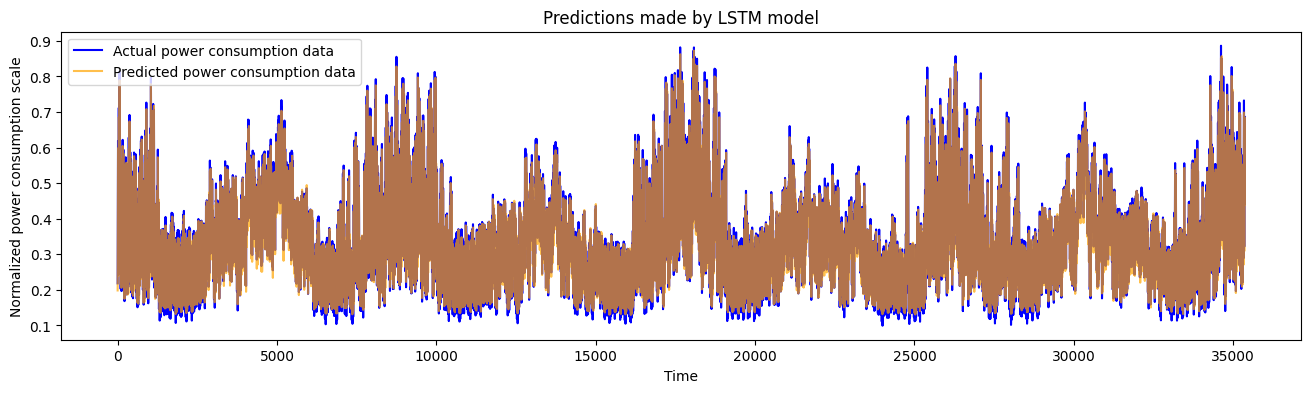

In [119]:
lstm_predictions = lstm_model.predict(X_test)

lstm_score = r2_score(y_test, lstm_predictions)
print("R^2 Score of LSTM model = ",lstm_score)
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(test, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()
plot_predictions(y_test, lstm_predictions, "Predictions made by LSTM model")

In [120]:
y_test_inverse = scaler.inverse_transform(y_test.reshape(-1, 1))
lstm_predictions_inverse = scaler.inverse_transform(lstm_predictions)

y_test_inverse = y_test_inverse.flatten()
lstm_predictions_inverse = lstm_predictions_inverse.flatten()

In [121]:
last_6169_index_dates = df.index[-35372:]

In [122]:
results_LSTM = pd.DataFrame({"Date":last_6169_index_dates, 'Actual': y_test_inverse, 'Predicted': lstm_predictions_inverse})
results_LSTM

Date   Actual     Predicted
0     2014-07-21 05:00:00  24908.0  23959.730469
1     2014-07-21 06:00:00  26345.0  25288.291016
2     2014-07-21 07:00:00  28392.0  28147.562500
3     2014-07-21 08:00:00  31012.0  30542.808594
4     2014-07-21 09:00:00  33221.0  32280.617188
...                   ...      ...           ...
35367 2018-08-02 20:00:00  44057.0  44102.468750
35368 2018-08-02 21:00:00  43256.0  42339.171875
35369 2018-08-02 22:00:00  41552.0  40735.679688
35370 2018-08-02 23:00:00  38500.0  38584.265625
35371 2018-08-03 00:00:00  35486.0  35382.828125

[35372 rows x 3 columns]

In [126]:
interval = 24 * 30

x_true, y_true = results_LSTM.iloc[:interval].Date, results_LSTM.iloc[:interval].Actual
x_pred, y_pred = results_LSTM.iloc[:interval].Date, results_LSTM.iloc[:interval].Predicted

fig = go.Figure()
fig.add_trace(go.Scatter(x=x_true, y=y_true,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=x_pred, y=y_pred,
                         mode='lines', 
                         name='Test - Prediction'))

fig.update_traces(line=dict(width=0.9))
fig.update_layout(title=f'Prophet Intra-Day Forecast of First {interval} Hours of Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

print(f'MAPE for interval of the first {interval} hours: {mape(y_true, y_pred)}')

MAPE for interval of the first 720 hours: 1.66%
